In [42]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread
import scipy
from skimage.transform import resize
from PIL import Image
from scipy import ndimage
from dnn_app_utils import *
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
x, y = load_data()

In [43]:
train_x, test_x, train_y, test_y =  train_test_split(x, y, test_size=0.33, random_state=84)

In [44]:
tr = np.array(train_y)
ts = np.array(test_y)

print("Number of PIZZAS in training: {}".format(len(np.where(tr == 1)[0])))
print("Number of NON-PIZZAS in training: {}".format(len(np.where(tr == 0)[0])))

print("Number of PIZZAS in test: {}".format(len(np.where(ts == 1)[0])))
print("Number of NON-PIZZAS in test: {}".format(len(np.where(ts == 0)[0])))

Number of PIZZAS in training: 660
Number of NON-PIZZAS in training: 343
Number of PIZZAS in test: 313
Number of NON-PIZZAS in test: 182


In [45]:
train_x_orig = np.array(train_x)
test_x_orig = np.array(test_x)
train_y = np.array([train_y])
test_y = np.array([test_y])

In [46]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

In [47]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten
test_x = test_x_flatten

In [48]:
def compute_cost_with_regularization(AL, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    
    cross_entropy_cost = compute_cost(AL, Y) # This gives you the cross-entropy part of the cost
    
    matrix_sum = 0 #initialize the sum at zero
    
    for key in parameters:
        if(str(key)[0] == "W"):
            matrix_sum += np.sum(np.square(parameters[key]))
        
    L2_regularization_cost = (lambd/(2*m))*(matrix_sum)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [49]:
def L_layer_model(X, Y, layers_dims, test_x, test_y, lambd, learning_rate = 0.007, num_iterations = 3000, print_cost=False, 
                 l_decay = False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = [] # keep track of cost
    prediction_test = [] # keep track of the prediction accuracy
    
    # Parameters initialization.
    parameters = initialize_parameters_he(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        
        if(i % 300 == 0 and i != 0 and l_decay):
            learning_rate /= 2
            print("Learning rate: ", learning_rate)

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)

        # Compute cost.
        if lambd == 0:
            cost = compute_cost(AL, Y)
        else:
            cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
    
        # Backward propagation.
        if lambd == 0:
            grads = back_propagation(AL, Y, caches)
        else:
            grads = backward_with_regularization(AL, Y, caches, lambd)
            
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            
            p, accuracy = predict(test_x, test_y, parameters) #predict the test_data
            print("Accuracy: {0}".format(accuracy))
            
            print ("Cost after iteration %i: %f" %(i, cost))            
            print("---------------------------------------")
            
            costs.append(cost)
            prediction_test.append(float(accuracy))
        

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.plot(np.squeeze(prediction_test), 'ro')
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.grid(True)
    plt.show()
    
    return parameters

In [50]:
layers_dims = [12288, 20, 20, 20, 15, 10, 7, 5, 1] #  8-layer model

Accuracy: 0.6303030303030301
Cost after iteration 0: 0.659779
---------------------------------------
Accuracy: 0.7414141414141412
Cost after iteration 100: 0.546428
---------------------------------------
Accuracy: 0.7575757575757573
Cost after iteration 200: 0.477982
---------------------------------------
Accuracy: 0.7434343434343433
Cost after iteration 300: 0.462375
---------------------------------------
Accuracy: 0.7595959595959594
Cost after iteration 400: 0.428819
---------------------------------------
Accuracy: 0.7353535353535352
Cost after iteration 500: 0.454040
---------------------------------------
Accuracy: 0.7393939393939393
Cost after iteration 600: 0.450727
---------------------------------------
Accuracy: 0.7575757575757573
Cost after iteration 700: 0.333684
---------------------------------------
Accuracy: 0.721212121212121
Cost after iteration 800: 0.361944
---------------------------------------
Accuracy: 0.7797979797979795
Cost after iteration 900: 0.265858
---

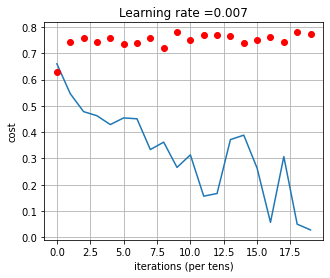

In [51]:
parameters = L_layer_model(train_x, train_y, layers_dims, test_x, test_y, 0, num_iterations = 1800, print_cost = True)

In [52]:
pred_train, acc = predict(train_x, train_y, parameters)
print("Acc: ", acc) # 0.9880358923230306

Acc:  0.9980059820538382


In [53]:
pred_test, acc = predict(test_x, test_y, parameters)
print("Acc: ", acc) # 0.7414141414141412

Acc:  0.7737373737373736


In [15]:
analysis = false_and_positives_analysis(pred_test, test_y)

The number of FALSE POSITIVES were:  86
The number of FALSE NEGATIVES were:  60
The number of TRUE POSITIVES were:  237
The number of TRUE NEGATIVES were:  110
